<a href="https://colab.research.google.com/github/delhian/NLP_course/blob/master/text_classification/3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Классификация текстов</center></h1>

Сегодня мы подробнее познакомимся с задачей классификации текстов на два или более классов.

У нас есть [набор данных отзывов на фильмы IMDB](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), который часто используют при разработке и оценке моделей классификации текстов. Каждый из отзывов в наборе данных имеет свою оценку: является ли он позитивным или негативным.

**Цель:** Используя данные отзывов IMDB, построить модель, которая на основе текста отзыва сможет определять, относится ли он к позитивнму или к негативному классу.

## План работы
* Подготовка данных
* Классификация с помощью Word2Vec:
    * Обучение модели Word2Vec
    * Построение векторов для текстов через среднее векторов слов
    * Построение векторов для текстов через средневзвешенное векторов слов
* Классификация с помощью FastText
* Классификация с помощью сверточной нейронной сети (CNN)

## Подготовка данных



Для обучения нейросетевых моделей (далее) мы будем использовать популярный фреймворк [PyTorch](https://pytorch.org/).

В предположении, что PyTorch уже установлен, поставим дополнительные модули (torchvision и torchtext) и загрузим модель для токенизации:

In [1]:
!pip install torchvision

In [2]:
!pip install torchtext

Загрузим датасет IMDB из torchtext, это будет удобно для дальнейшего использования этих данных при обучении нейронной сети.

In [3]:
import numpy as np
import torch
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report,confusion_matrix
from torchtext.legacy import data
from torchtext import datasets
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter,defaultdict
%matplotlib inline
import seaborn as sns

print(torch.__version__)

SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField()

1.9.0+cu111


Разделим данные на обучаующую и тестовую выборку и преобразуем их в формат, удобный для построения классических моделей машинного обучения.

In [4]:
%%time

train_src, test = datasets.IMDB()

X_train, X_test, y_train, y_test = [], [], [], []

def tokenize(line):
    return line.split()

for label, line in train_src:
  X_train.append(tokenize(line))
  y_train.append(label)

for label, line in test:
  X_test.append(tokenize(line))
  y_test.append(label)

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:05<00:00, 15.9MB/s]


CPU times: user 29.8 s, sys: 11.7 s, total: 41.5 s
Wall time: 46.7 s


In [5]:
from collections import Counter

print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

train_counter = Counter(y_train)
test_counter = Counter(y_test)

print ("{0} positive and {1} negative examples in test".format(test_counter['pos'],test_counter['neg']))
print ("{0} positive and {1} negative examples in test".format(test_counter['pos'],test_counter['neg']))

total train examples 25000
total test examples 25000
12500 positive and 12500 negative examples in test
12500 positive and 12500 negative examples in test


Можно видеть, что классы сбалансированы: количество позитивных и негативных отзывов совпадают.

Посмотрим на примеры позитивного и негативного отзыва.

In [6]:
print("Negative example:\n{0}\n\n".format(' '.join(X_train[0])))
print("Positive example:\n{0}\n\n".format(' '.join(X_train[-1])))

Negative example:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few an

## Классификация с помощью Word2Vec

Подробно языковая модель *Word2Vec* была рассмотрена на предыдущей неделе курса.

Здесь мы будем использовать эту модель для получения векторных представлений слов.

In [7]:
from gensim.models import Word2Vec
model = Word2Vec(X_train, size=100, window=5, min_count=5, workers=4)
model.save("word2vec.model")

In [8]:
w2v_model = Word2Vec.load("word2vec.model")

Чтобы решить задачу классификации текстов, нам нужно каждому тексту поставить в соответствие вектор.

Реализуем класс *MeanEmbeddingVectorizer*, с помощью которого будем получать вектора для текстов отзывов на основе векторов слов.
Вектор каждого текста будет равен среднему векторов входящих в него слов.

In [9]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

Попробуем также немного другой подход $-$ будем получать вектор для текста как средневзвешенное векторов входящих в него слов с весами *tf-idf*.

Для этого реализуем класс *TfidfEmbeddingVectorizer*.

In [10]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Преобразуем модель Word2Vec в словарь для дальнейшего использования для векторизации текстов.

In [11]:
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


Для классификации будем использовать модель [случайного леса](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) из scikit-learn.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

In [13]:
%time rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

CPU times: user 10.7 s, sys: 188 ms, total: 10.9 s
Wall time: 10.9 s


Построим отчет по предсказаниям модели (с помощью MeanEmbeddingVectorizer) на тестовой выборке. Выведем точность (precision), полноту (recall) и f1-меру для позитивного и негативного классов, а также количество объектов каждого класса (support) в тестовой выборке.

Precision:   0.69
Recall:   0.69
F1-measure:   0.69
Accuracy:   0.69
              precision    recall  f1-score   support

         neg       0.68      0.73      0.71     12500
         pos       0.71      0.65      0.68     12500

    accuracy                           0.69     25000
   macro avg       0.69      0.69      0.69     25000
weighted avg       0.69      0.69      0.69     25000



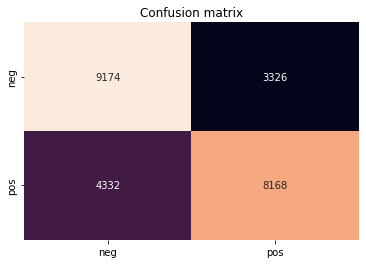

In [14]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

В данном случае классы сбалансированы (количество объектов позитивного и негативного классов совпадают), поэтому в качестве метрики качества можно использовать *accuracy*.

In [15]:
%time rfc_w2v_tfidf.fit(X_train,y_train)
pred = rfc_w2v_tfidf.predict(X_test)

CPU times: user 9min 5s, sys: 16.8 s, total: 9min 22s
Wall time: 9min 21s


Теперь выведем результаты работы классификатора на признаках из *TfidfEmbeddingVectorizer*.

Precision:   0.72
Recall:   0.72
F1-measure:   0.72
Accuracy:   0.72
              precision    recall  f1-score   support

         neg       0.70      0.76      0.73     12500
         pos       0.74      0.68      0.71     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000



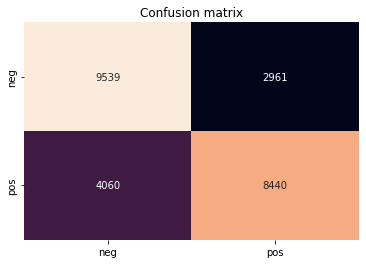

In [16]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Precision:   0.72
Recall:   0.72
F1-measure:   0.72
Accuracy:   0.72
              precision    recall  f1-score   support

         neg       0.70      0.76      0.73     12500
         pos       0.74      0.68      0.71     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000



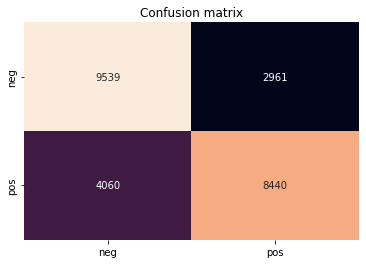

In [17]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Можно видеть, что при использовании *TfidfEmbeddingVectorizer* метрика Accuracy немного увеличилась по сравнению c *MeanEmbeddingVectorizer* $-$ с 0.60 до 0.62.

## Классификация с помощью FastText

Теперь попробуем классифицировать тексты с помощью другой языковой модели [FastText](https://github.com/facebookresearch/fasttext), которая также была описана в предыдущем занятии.

Чтобы использовать модель, подготовим для нее данные, записав тексты и их метки классов в файлы data.train.txt и text.txt

In [18]:
pip install fasttext  > /dev/null

In [19]:
import fasttext

N = -1

with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ ' '.join(X_train[i]) + '\n')
    
with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + y_test[i] + ' ' + ' '.join(X_test[i]) + '\n')

Будем использовать встроенную в fasttext модель классификации (логистическая регрессия) с помощью метода train_supervised.

In [20]:
%%time
classifier = fasttext.train_supervised('data.train.txt', epoch = 2000)#, 'model')
result = classifier.test('test.txt')
print('P@1:', result[1])#.precision)
print('R@1:', result[2])#.recall)
print('Number of examples:', result[0])#.nexamples)

P@1: 0.84416
R@1: 0.84416
Number of examples: 25000
CPU times: user 1h 4min 16s, sys: 32.9 s, total: 1h 4min 49s
Wall time: 1h 4min 29s


Precision:   0.84
Recall:   0.84
F1-measure:   0.84
Accuracy:   0.84
              precision    recall  f1-score   support

         neg       0.84      0.84      0.84     12500
         pos       0.84      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



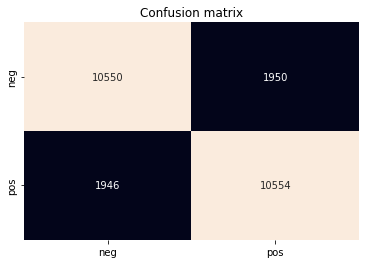

In [21]:
pred = classifier.predict([' '.join(x) for x in X_test])[0]
pred = [label[0].split("_")[-1] for label in pred]

print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))#[i[0] for i in pred]))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Можно видеть, что качество классификации при использовании FastText существенно увеличилось по сравнению с моделях на основе Word2Vec.